float64
float64
4-3-3
Position             Player Overall
     GK           M. Neuer      92
     LB            Marcelo      87
     CB       Sergio Ramos      90
     CB       G. Chiellini      89
     RB           Carvajal      84
     LM         C. Eriksen      87
    CDM           T. Kroos      90
     RM       K. De Bruyne      89
     LW             Neymar      92
     ST  Cristiano Ronaldo      94
     RW           L. Messi      93
3-5-2
Position        Player Overall
     GK      M. Neuer      92
    LWB       D. Rose      82
     CB  Sergio Ramos      90
    RWB     K. Walker      83
     LM    C. Eriksen      87
    CDM      T. Kroos      90
    CAM      Coutinho      86
     CM      N. Kanté      87
     RM  K. De Bruyne      89
     LW        Neymar      92
     RW      L. Messi      93
4-2-3-1
Position             Player Overall
     GK           M. Neuer      92
     LB            Marcelo      87
     CB       Sergio Ramos      90
     CB       G. Chiellini      89
     R

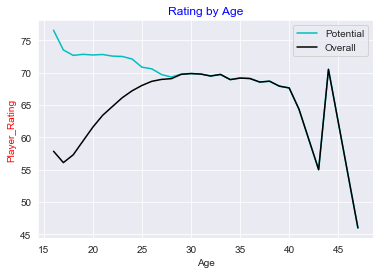

                   Name  Overall  growth               Club  \
11397          A. Gomes       64      26  Manchester United   
17123        C. Gregory       54      26         Shrewsbury   
17950           D. Amos       48      26   Doncaster Rovers   
17961  J. Latibeaudiere       47      26    Manchester City   
17515         M. Cooper       52      25    Plymouth Argyle   
17849      S. Sessegnon       50      25             Fulham   
15103         R. Nelson       59      24            Arsenal   
15837         J. Romero       58      24   Atlético Tucumán   
16374       L. Plogmann       57      24   Werder Bremen II   
17025         L. Pintor       54      24  Stade Brestois 29   

      Preferred Positions  
11397       CM RW LW CAM   
17123                 GK   
17950              LM LB   
17961                 CB   
17515                 GK   
17849              CB RB   
15103                 RM   
15837                 ST   
16374                 GK   
17025                 ST  

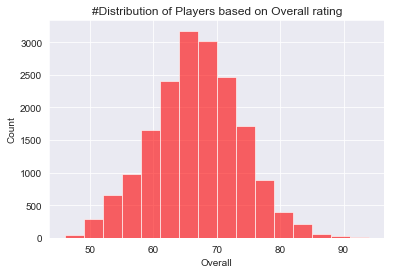

Mean squared error using linear regression: 29.02


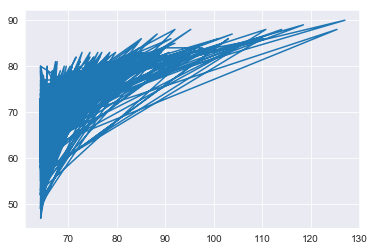

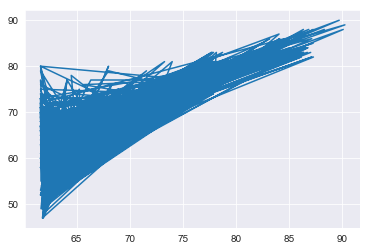

Mean squared error using svr: 13.85


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
import matplotlib.cm as cm
import re
sns.set_style("darkgrid")
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
dataset = pd.read_csv("CompleteDataset.csv", low_memory=False)
dataset.columns
dataset.head()

def conversion(money_str):
    notes = ''
    # Find the numbers and append
    for letter in money_str:
        if letter in '1234567890.':
            notes = notes + letter
        else:
            pass
    # Divide by 1000 to convert K to M for value
    if 'K' in money_str:
        return (float(notes)/1000)    
    else:
        return float(notes)

def wage_conversion(money_str):
    notes = ''
    # Find the numbers and append
    for letter in money_str:
        if letter in '1234567890.':
            notes = notes + letter
        else:
            pass
    
    return float(notes)

def convert_attributes(number_str):
    if type(number_str) == str:
        if '+' in number_str:
            return float(number_str.split('+')[0])
        elif '-' in number_str:
            return float(number_str.split('-')[0])
        else:
            return float(number_str)


#Data Conversion
dataset['Wage'] = dataset['Wage'].apply(wage_conversion) # Units = K
print(dataset['Wage'][-10:].dtype)
dataset['Value'] = dataset['Value'].apply(conversion) # Units = M
print(dataset['Value'][-10:].dtype)

dataset['Remaining Potential'] = dataset['Potential'] - dataset['Overall']

dataset['Preferred Position'] = dataset['Preferred Positions'].str.split().str[0]


###Best 11 based on overall rating in fifa data set
def formation_best_squad(position):
    dataset_copy = dataset.copy()
    store = []
    for i in position:
        store.append([i,dataset_copy.loc[[dataset_copy[dataset_copy["Preferred Position"] == i]["Overall"].idxmax()]]['Name'].to_string(index = False), dataset_copy[dataset_copy['Preferred Position'] == i]['Overall'].max()])
        dataset_copy.drop(dataset_copy[dataset_copy['Preferred Position'] == i]['Overall'].idxmax(), inplace = True)
    #return store
    return pd.DataFrame(np.array(store).reshape(11,3), columns = ['Position', 'Player', 'Overall']).to_string(index = False)

# 4-3-3
formation433 = ['GK', 'LB', 'CB', 'CB', 'RB', 'LM', 'CDM', 'RM', 'LW', 'ST', 'RW']
print ('4-3-3')
print (formation_best_squad(formation433))

#3-5-2
formation352 = ['GK', 'LWB', 'CB', 'RWB', 'LM', 'CDM', 'CAM', 'CM', 'RM', 'LW', 'RW']
print ('3-5-2')
print (formation_best_squad(formation352))

##4-2-3-1
formation4231=['GK','LB','CB','CB','RB','CDM','CDM','LM','CAM','RM','ST']
print('4-2-3-1')
print(formation_best_squad(formation4231))
##potential against overall rating based on age parameter
##basic visualization


dataset_potential = dataset.groupby(['Age'])['Potential'].mean()
dataset_overall = dataset.groupby(['Age'])['Overall'].mean()

dataset_summary = pd.concat([dataset_potential, dataset_overall], axis=1)

ax = dataset_summary.plot(color='C0,C1')
ax.set_ylabel('Player_Rating',color='r')
ax.set_title('Rating by Age',color='b')
plt.show()


###Top potential low rated players 
dataframe=dataset
dataframe['growth']=dataframe['Potential']-dataframe['Overall']
high_potential=dataframe[['Name','Overall','growth','Club','Preferred Positions']]
Top_Growths=high_potential.sort_values(by=['growth','Overall'],ascending=False)
print(Top_Growths[:10])

####Top 20 players
Top=dataset[['Name','Age','Preferred Positions','Overall']]
Top_20=Top.sort_values(by=['Overall'],ascending=False)
print(Top_20[:20])

#######Machine Learning

mldf=dataset[['Name','Value','Overall','Age','Finishing']]


##To remove non-numeric values in Finishing column

def numeric_values(s):
    try:
        n = int(s)
        return (1 <= n and n <= 99)
    except ValueError:
        return False
 #remove not valid entries for Finishing
mldf = mldf.loc[mldf['Finishing'].apply(lambda x: numeric_values(x))]
 
#now we can define Finishing as integers
mldf['Finishing'] = mldf['Finishing'].astype('int')

####Distribution of players 
plt.hist(dataset.Overall, bins=16, alpha=0.6, color='r')
plt.title("#Distribution of Players based on Overall rating")
plt.xlabel("Overall")
plt.ylabel("Count")
 
plt.show()

##Machine Learning(Linear regression)
##Data Slicing
##Dividing data using model selection 
from sklearn.model_selection import train_test_split
 
train, test = train_test_split(mldf, test_size=0.20, random_state=99)
 
xtrain = train[['Value']]
ytrain = train[['Overall']]
 
xtest = test[['Value']]
ytest = test[['Overall']]

regression = linear_model.LinearRegression()
regression.fit(xtrain, ytrain)

#Predicting y using test data set
y_predictions = regression.predict(xtest)

print("Mean squared error using linear regression: %.2f" % mean_squared_error(ytest, y_predictions))
plt.plot(y_predictions,ytest)
plt.show()

####Using another model support vector regression (radial basis function for non linear problems) 
SVR_dataset = SVR(kernel='rbf', gamma=1e-3, C=100, epsilon=0.1)
SVR_dataset.fit(xtrain, ytrain.values.ravel())

radial_function = SVR_dataset.predict(xtest)
plt.plot(radial_function,ytest)
plt.show()

print("Mean squared error using svr: %.2f" % mean_squared_error(ytest, radial_function))


In [34]:
import pandas as pd
dataset = pd.read_csv("CompleteDataset.csv", low_memory=False)
dataset

,Unnamed: 0,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,...,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
0,0,Cristiano Ronaldo,32,https://cdn.sofifa.org/48/18/players/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Real Madrid CF,https://cdn.sofifa.org/24/18/teams/243.png,...,61.0,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,92.0
1,1,L. Messi,30,https://cdn.sofifa.org/48/18/players/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,93,93,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,...,57.0,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,88.0
2,2,Neymar,25,https://cdn.sofifa.org/48/18/players/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,94,Paris Saint-Germain,https://cdn.sofifa.org/24/18/teams/73.png,...,59.0,46.0,79.0,59.0,88.0,87.0,84.0,89.0,64.0,84.0
3,3,L. Suárez,30,https://cdn.sofifa.org/48/18/players/176580.png,Uruguay,https://cdn.sofifa.org/flags/60.png,92,92,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,...,64.0,58.0,80.0,65.0,88.0,85.0,88.0,87.0,68.0,88.0
4,4,M. Neuer,31,https://cdn.sofifa.org/48/18/players/167495.png,Germany,https://cdn.sofifa.org/flags/21.png,92,92,FC Bayern Munich,https://cdn.sofifa.org/24/18/teams/21.png,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,R. Lewandowski,28,https://cdn.sofifa.org/48/18/players/188545.png,Poland,https://cdn.sofifa.org/flags/37.png,91,91,FC Bayern Munich,https://cdn.sofifa.org/24/18/teams/21.png,...,58.0,57.0,78.0,62.0,87.0,82.0,88.0,84.0,61.0,88.0
6,6,De Gea,26,https://cdn.sofifa.org/48/18/players/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,90,92,Manchester United,https://cdn.sofifa.org/24/18/teams/11.png,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,E. Hazard,26,https://cdn.sofifa.org/48/18/players/183277.png,Belgium,https://cdn.sofifa.org/flags/7.png,90,91,Chelsea,https://cdn.sofifa.org/24/18/teams/5.png,...,59.0,47.0,81.0,61.0,87.0,87.0,82.0,88.0,64.0,82.0
8,8,T. Kroos,27,https://cdn.sofifa.org/48/18/players/182521.png,Germany,https://cdn.sofifa.org/flags/21.png,90,90,Real Madrid CF,https://cdn.sofifa.org/24/18/teams/243.png,...,76.0,72.0,87.0,82.0,81.0,81.0,77.0,80.0,78.0,77.0
9,9,G. Higuaín,29,https://cdn.sofifa.org/48/18/players/167664.png,Argentina,https://cdn.sofifa.org/flags/52.png,90,90,Juventus,https://cdn.sofifa.org/24/18/teams/45.png,...,51.0,46.0,71.0,52.0,84.0,79.0,87.0,82.0,55.0,87.0


In [30]:
dataset['Wage']

0        €565K
1        €565K
2        €280K
3        €510K
4        €230K
5        €355K
6        €215K
7        €295K
8        €340K
9        €275K
10       €310K
11       €285K
12       €190K
13       €265K
14       €340K
15       €370K
16       €325K
17       €225K
18       €110K
19       €215K
20        €82K
21       €150K
22       €225K
23       €165K
24       €210K
25       €215K
26       €125K
27       €215K
28       €265K
29       €165K
         ...  
17951      €1K
17952      €1K
17953      €1K
17954      €1K
17955      €1K
17956      €1K
17957      €1K
17958      €1K
17959      €1K
17960      €1K
17961      €5K
17962      €1K
17963      €1K
17964      €1K
17965      €1K
17966      €1K
17967      €1K
17968      €1K
17969      €1K
17970      €1K
17971      €2K
17972      €1K
17973      €1K
17974      €1K
17975      €1K
17976      €1K
17977      €1K
17978      €1K
17979      €1K
17980      €1K
Name: Wage, Length: 17981, dtype: object

In [31]:
def wage_conversion(money_str):
    notes = ''
    # Find the numbers and append
    for letter in money_str:
        if letter in '1234567890.':
            notes = notes + letter
        else:
            pass
    
    return float(notes)
dataset['Wage'] = dataset['Wage'].apply(wage_conversion)# Units = K
print(dataset['Wage'])
print(dataset['Wage'][:].dtype)

0        565.0
1        565.0
2        280.0
3        510.0
4        230.0
5        355.0
6        215.0
7        295.0
8        340.0
9        275.0
10       310.0
11       285.0
12       190.0
13       265.0
14       340.0
15       370.0
16       325.0
17       225.0
18       110.0
19       215.0
20        82.0
21       150.0
22       225.0
23       165.0
24       210.0
25       215.0
26       125.0
27       215.0
28       265.0
29       165.0
         ...  
17951      1.0
17952      1.0
17953      1.0
17954      1.0
17955      1.0
17956      1.0
17957      1.0
17958      1.0
17959      1.0
17960      1.0
17961      5.0
17962      1.0
17963      1.0
17964      1.0
17965      1.0
17966      1.0
17967      1.0
17968      1.0
17969      1.0
17970      1.0
17971      2.0
17972      1.0
17973      1.0
17974      1.0
17975      1.0
17976      1.0
17977      1.0
17978      1.0
17979      1.0
17980      1.0
Name: Wage, Length: 17981, dtype: float64
float64


In [32]:
dataset['Value']

0        €95.5M
1         €105M
2         €123M
3          €97M
4          €61M
5          €92M
6        €64.5M
7        €90.5M
8          €79M
9          €77M
10         €52M
11         €83M
12         €59M
13       €67.5M
14         €57M
15       €69.5M
16       €66.5M
17         €38M
18        €4.5M
19         €79M
20         €57M
21         €75M
22       €70.5M
23         €61M
24         €44M
25         €48M
26         €40M
27         €48M
28         €60M
29         €38M
          ...  
17951      €40K
17952      €60K
17953      €60K
17954      €60K
17955      €60K
17956      €50K
17957      €50K
17958      €40K
17959      €60K
17960      €70K
17961      €60K
17962      €50K
17963      €50K
17964      €60K
17965      €60K
17966      €60K
17967      €60K
17968      €60K
17969      €60K
17970      €40K
17971      €60K
17972      €60K
17973      €50K
17974      €40K
17975      €30K
17976      €50K
17977        €0
17978      €60K
17979      €60K
17980      €50K
Name: Value, Length: 179

In [35]:
dataset['Remaining Potential']

KeyError: 'Remaining Potential'

In [38]:
import pandas as pd
dataset = pd.read_csv("CompleteDataset.csv", low_memory=False)
list(dataset.columns.values)

['Unnamed: 0',
 'Name',
 'Age',
 'Photo',
 'Nationality',
 'Flag',
 'Overall',
 'Potential',
 'Club',
 'Club Logo',
 'Value',
 'Wage',
 'Special',
 'Acceleration',
 'Aggression',
 'Agility',
 'Balance',
 'Ball control',
 'Composure',
 'Crossing',
 'Curve',
 'Dribbling',
 'Finishing',
 'Free kick accuracy',
 'GK diving',
 'GK handling',
 'GK kicking',
 'GK positioning',
 'GK reflexes',
 'Heading accuracy',
 'Interceptions',
 'Jumping',
 'Long passing',
 'Long shots',
 'Marking',
 'Penalties',
 'Positioning',
 'Reactions',
 'Short passing',
 'Shot power',
 'Sliding tackle',
 'Sprint speed',
 'Stamina',
 'Standing tackle',
 'Strength',
 'Vision',
 'Volleys',
 'CAM',
 'CB',
 'CDM',
 'CF',
 'CM',
 'ID',
 'LAM',
 'LB',
 'LCB',
 'LCM',
 'LDM',
 'LF',
 'LM',
 'LS',
 'LW',
 'LWB',
 'Preferred Positions',
 'RAM',
 'RB',
 'RCB',
 'RCM',
 'RDM',
 'RF',
 'RM',
 'RS',
 'RW',
 'RWB',
 'ST']

In [39]:
dataset['Remaining Potential'] = dataset['Potential'] - dataset['Overall']

In [40]:
dataset.columns.values

array(['Unnamed: 0', 'Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage',
       'Special', 'Acceleration', 'Aggression', 'Agility', 'Balance',
       'Ball control', 'Composure', 'Crossing', 'Curve', 'Dribbling',
       'Finishing', 'Free kick accuracy', 'GK diving', 'GK handling',
       'GK kicking', 'GK positioning', 'GK reflexes', 'Heading accuracy',
       'Interceptions', 'Jumping', 'Long passing', 'Long shots',
       'Marking', 'Penalties', 'Positioning', 'Reactions',
       'Short passing', 'Shot power', 'Sliding tackle', 'Sprint speed',
       'Stamina', 'Standing tackle', 'Strength', 'Vision', 'Volleys',
       'CAM', 'CB', 'CDM', 'CF', 'CM', 'ID', 'LAM', 'LB', 'LCB', 'LCM',
       'LDM', 'LF', 'LM', 'LS', 'LW', 'LWB', 'Preferred Positions', 'RAM',
       'RB', 'RCB', 'RCM', 'RDM', 'RF', 'RM', 'RS', 'RW', 'RWB', 'ST',
       'Remaining Potential'], dtype=object)

In [41]:
dataset['Remaining Potential']

0         0
1         0
2         2
3         0
4         0
5         0
6         2
7         1
8         0
9         0
10        0
11        3
12        3
13        0
14        0
15        0
16        0
17        0
18        0
19        5
20        5
21        3
22        2
23        0
24        0
25        0
26        0
27        0
28        0
29        0
         ..
17951    10
17952    20
17953    19
17954    16
17955    15
17956    16
17957    14
17958    12
17959    17
17960    22
17961    26
17962    16
17963    11
17964    20
17965    14
17966    20
17967    20
17968    21
17969    20
17970     9
17971    18
17972    16
17973    12
17974    10
17975     0
17976    17
17977     0
17978    15
17979    18
17980    18
Name: Remaining Potential, Length: 17981, dtype: int64

In [48]:
dataset['Preferred Position'] = dataset['Preferred Positions'].str.split().str[0]

In [49]:
dataset['Preferred Position']

0         ST
1         RW
2         LW
3         ST
4         GK
5         ST
6         GK
7         LW
8        CDM
9         ST
10        CB
11        RM
12        GK
13        RM
14       CDM
15        RW
16        ST
17        CB
18        GK
19        ST
20        GK
21        LW
22       CDM
23        ST
24        CB
25        CB
26        CB
27        CB
28        RW
29        GK
        ... 
17951     GK
17952     CM
17953     RB
17954     LM
17955     CM
17956     CB
17957     RB
17958     CB
17959    CAM
17960    CAM
17961     CB
17962     CB
17963     CM
17964     CM
17965     CM
17966     CM
17967     RB
17968     CB
17969     ST
17970     CB
17971     ST
17972     CB
17973     CM
17974     CB
17975     CM
17976     GK
17977     GK
17978     ST
17979     CM
17980     ST
Name: Preferred Position, Length: 17981, dtype: object

In [50]:
dataset['Age']

0        32
1        30
2        25
3        30
4        31
5        28
6        26
7        26
8        27
9        29
10       31
11       26
12       25
13       28
14       31
15       27
16       29
17       32
18       39
19       23
20       24
21       26
22       26
23       28
24       30
25       28
26       31
27       28
28       28
29       30
         ..
17951    21
17952    17
17953    18
17954    19
17955    18
17956    17
17957    17
17958    17
17959    18
17960    18
17961    17
17962    18
17963    19
17964    18
17965    18
17966    18
17967    19
17968    17
17969    18
17970    19
17971    18
17972    19
17973    18
17974    18
17975    28
17976    17
17977    47
17978    17
17979    18
17980    18
Name: Age, Length: 17981, dtype: int64

In [51]:
dataset['Potential']

0        94
1        93
2        94
3        92
4        92
5        91
6        92
7        91
8        90
9        90
10       90
11       92
12       92
13       89
14       89
15       89
16       89
17       89
18       89
19       93
20       93
21       91
22       90
23       88
24       88
25       88
26       88
27       88
28       88
29       88
         ..
17951    58
17952    68
17953    67
17954    64
17955    63
17956    64
17957    61
17958    59
17959    64
17960    69
17961    73
17962    63
17963    58
17964    67
17965    61
17966    67
17967    67
17968    68
17969    67
17970    56
17971    65
17972    63
17973    58
17974    56
17975    46
17976    63
17977    46
17978    61
17979    64
17980    64
Name: Potential, Length: 17981, dtype: int64

In [56]:
dataset_potential = dataset.groupby(['Age'])['Potential'].mean()

In [57]:
print(dataset_potential)

Age
16    76.538462
17    73.492248
18    72.654762
19    72.815716
20    72.717269
21    72.790047
22    72.542296
23    72.489957
24    72.090705
25    70.836399
26    70.574875
27    69.697917
28    69.304472
29    69.763604
30    69.853234
31    69.767511
32    69.468379
33    69.709887
34    68.911765
35    69.151832
36    69.080882
37    68.536232
38    68.666667
39    67.900000
40    67.625000
41    64.333333
43    55.000000
44    70.500000
47    46.000000
Name: Potential, dtype: float64


In [58]:
dataset_overall = dataset.groupby(['Age'])['Overall'].mean()

In [59]:
dataset_overall

Age
16    57.846154
17    56.089147
18    57.287202
19    59.430309
20    61.559839
21    63.395023
22    64.762085
23    66.117647
24    67.182909
25    68.008541
26    68.643927
27    68.943576
28    69.058040
29    69.722569
30    69.847015
31    69.767511
32    69.468379
33    69.709887
34    68.911765
35    69.151832
36    69.080882
37    68.536232
38    68.666667
39    67.900000
40    67.625000
41    64.333333
43    55.000000
44    70.500000
47    46.000000
Name: Overall, dtype: float64

In [60]:
dataset_summary = pd.concat([dataset_potential, dataset_overall], axis=1)

In [61]:
dataset_summary

,Potential,Overall
Age,,
16,76.538462,57.846154
17,73.492248,56.089147
18,72.654762,57.287202
19,72.815716,59.430309
20,72.717269,61.559839
21,72.790047,63.395023
22,72.542296,64.762085
23,72.489957,66.117647
24,72.090705,67.182909
